In [21]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np 
import pandas as pd
from numba import njit
import matplotlib.pyplot as plt
from math import isnan
import pickle
import gymnasium as gym
import torch.nn as nn
from stable_baselines3 import DQN
import torch
import plotly.graph_objects as go

from qrm_core.engine import simulate_QRM_jit
from qrm_core.sampling import sample_stationary_lob
from qrm_core.intensity import IntensityTable
from notebook_utils import to_dataframe, plot_overview, plot_gap_mean, plot_gap_variance

from pathlib import Path
ROOT = Path.cwd()
if (ROOT / "calibration_data").exists() is False and (ROOT.parent / "calibration_data").exists():
    ROOT = ROOT.parent
RESULTS_DIR = ROOT / "results"
CALIB_DIR = ROOT / "calibration_data"
MODELS_DIR = ROOT / "saved_models"
intensity_path = CALIB_DIR / "intensity_table.npy"
invariant_path = CALIB_DIR / "invariant_distribution.npy"

# I. QRM Simulations

Run the QRM simulation either 

1) up to a given time horizon with `time_end` (in seconds)

2) up to a maximum number of events in the LOB with `max_nb_events` (default to nan)

In [ ]:
# Simulation parameters
time_end = int(1e4)
max_nb_events = np.nan
tick = 0.01 # tick size
theta = 0.7
theta_reinit = 0.85
t0 = 0. # initial time
p_mid = 100.005 # initial mid price
p_ref = 100.005 # initial reference price
aes = [836, 1068, 1069] # avg. nb of shares per LOB event per depth (taken from the QRM paper, K=3)


# Random seed
seed = 2025
np.random.seed(seed)
@njit
def _init_numba(seed): np.random.seed(seed)
_init_numba(seed)

# Build intensity table
inten_arr = np.load(intensity_path)
K, Q1, *_ = inten_arr.shape
inten_table = IntensityTable(max_depth=K, max_queue=Q1-1)
inten_table._data = inten_arr
rate_int_all = np.transpose(inten_table._data, (2,0,1,3)).copy()

# Load invariant distribution
inv_bid = np.load(invariant_path)
inv_ask = np.load(invariant_path) # possibility of bid-ask asymmetry
state = np.empty(2*K, np.int8)

# Initial LOB state: sample from the invariant distribution
state[:K] = sample_stationary_lob(inv_bid, np.empty((0,), np.int8))
state[K:] = sample_stationary_lob(inv_ask, np.empty((0,), np.int8))

if isnan(max_nb_events):
    # stop at time horizon
    max_events_intra = 12 * int(time_end) # numpy length pre-allocation
    # 12 is a large upper bound on the number of events per second
    # might be too small for other calibrated intensities (in which case the code will throw an error)
else:
    # stop after maximum nb of events
    max_events_intra = max_nb_events

bid_idx = next((i for i in range(K) if state[i]>0), None)
ask_idx = next((i for i in range(K, 2*K) if state[i]>0), None)
if bid_idx is None or ask_idx is None:
    raise ValueError("Sampled empty LOB")
p_mid = 0.5 * ((p_ref + tick * (ask_idx - K + 0.5)) +
                    (p_ref - tick * (bid_idx + 0.5)))

times, p_mids, p_refs, sides, depths, events, redrawns, states = simulate_QRM_jit(t0,
                                                                                    p_mid,
                                                                                    p_ref,
                                                                                    state,
                                                                                    rate_int_all,
                                                                                    tick,
                                                                                    theta,
                                                                                    theta_reinit,
                                                                                    time_end,
                                                                                    inv_bid,
                                                                                    inv_ask, 
                                                                                    max_events_intra, 
                                                                                    aes, 
                                                                                    max_nb_events
                                                                                    )

times = times.astype(np.float64, copy=False)
df = to_dataframe(times, p_mids, p_refs, sides, depths, events, redrawns, states, K)
row_0 = [t0, p_mid, p_ref, -1, -1, -1, False] + state[:K].tolist()[::-1] + state[K:].tolist()
df = pd.concat([pd.DataFrame([row_0], columns=df.columns), df], ignore_index=True)
df

,time,p_mid,p_ref,side,depth,event,redrawn,q_bid3,q_bid2,q_bid1,q_ask1,q_ask2,q_ask3
0,0.000000,100.000,100.005,-1,-1,-1,False,33,23,0,3,11,13
1,0.006905,100.000,100.005,ask,1,cancel,False,33,23,0,2,11,13
2,0.033696,100.000,100.005,ask,1,limit,False,33,23,0,3,11,13
3,0.225402,100.000,100.005,ask,2,limit,False,33,23,0,3,12,13
4,0.550690,100.005,100.005,bid,1,limit,False,33,23,1,3,12,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...
65308,9998.966024,99.755,99.755,ask,1,limit,False,12,17,1,8,17,11
65309,9999.035834,99.755,99.755,ask,3,cancel,False,12,17,1,8,17,10
65310,9999.144458,99.755,99.755,bid,2,limit,False,12,18,1,8,17,10
65311,9999.258836,99.755,99.755,bid,1,limit,False,12,18,2,8,17,10


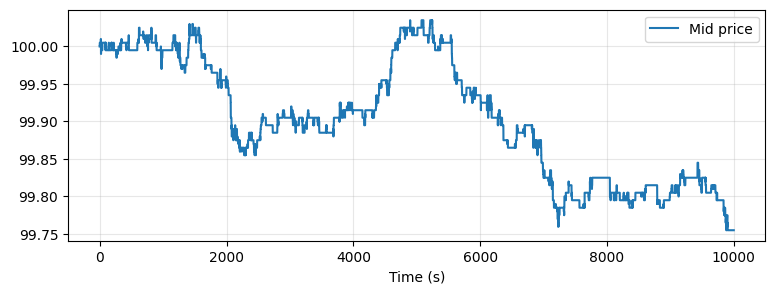

In [3]:
plt.figure(figsize=(9,3))
plt.plot(df['time'], df['p_mid'], label='Mid price')
plt.grid(alpha=0.3)
plt.legend()
plt.xlabel('Time (s)');

# II. Reinforcement Learning

- The model weights are saved in `saved_models/` (zip and pth files). The model showed in Section V of the paper corresponds to `5d_state_3d_action` (standing for 5 dimensional state space and 3 dimensional action space). The other models are those presented in Section C of the Appendix. 

- The results (i.e., the metrics) are saved in `results/` (these files are created by running `scripts/run_test.py`).

In [3]:
config_models = {'5d_state_3d_action': [5, 3], 
                 '5d_state_2d_action': [5, 2],
                 '4d_state_2d_action': [4, 2],
                 '3d_state_2d_action': [3, 2]}

## 5 dim state, 3 dim action

- `plot_overview` reproduces Figs. 8,9 & 10 of the paper.

- `plot_gap_mean` and `plot_gap_variance` reproduce Fig. 11 of the paper.

To plot the graphs for a different trained model, simply update `run_id` to the corresponding run identifier.

[TWAP] IS: mean=-0.365, std=0.652 

[POPV1] IS: mean=-0.343, std=0.378 

[POPV2] IS: mean=-0.342, std=0.472 

[POPV3] IS: mean=-0.400, std=0.388 

[POPV4] IS: mean=-0.399, std=0.437 

[DDQN] IS: mean=-0.259, std=0.631 

[TWAP] 0.0000% of runs did not reach full inventory
[POPV1] 0.0000% of runs did not reach full inventory
[POPV2] 0.0350% of runs did not reach full inventory
    Missing volume: avg=2.14, std=1.81, max=5.00

[POPV3] 0.0050% of runs did not reach full inventory
    Missing volume: avg=4.00, std=0.00, max=4.00

[POPV4] 0.2650% of runs did not reach full inventory
    Missing volume: avg=2.51, std=1.91, max=9.00

[DDQN] 0.0450% of runs did not reach full inventory
    Missing volume: avg=1.44, std=0.96, max=4.00



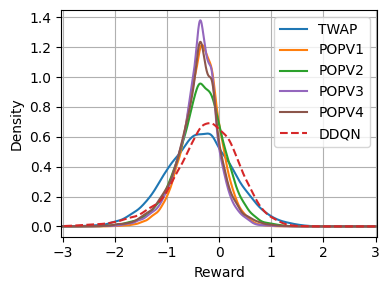

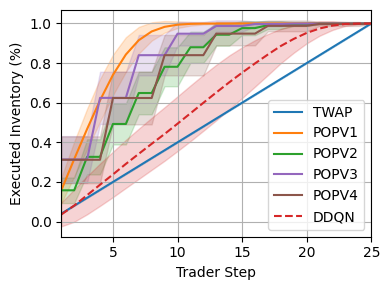

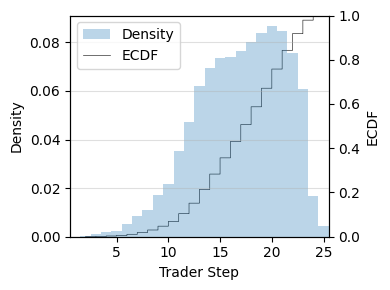

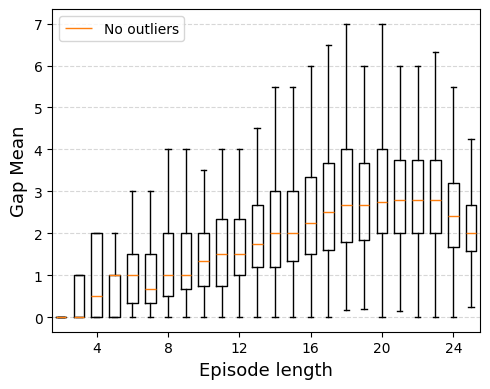

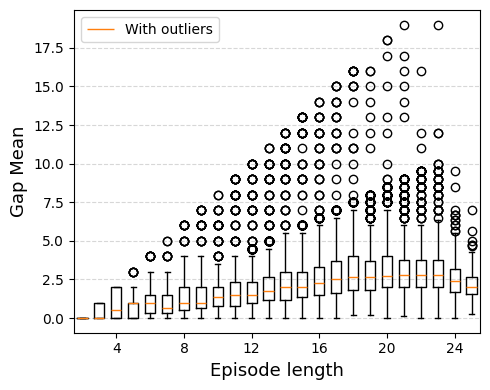

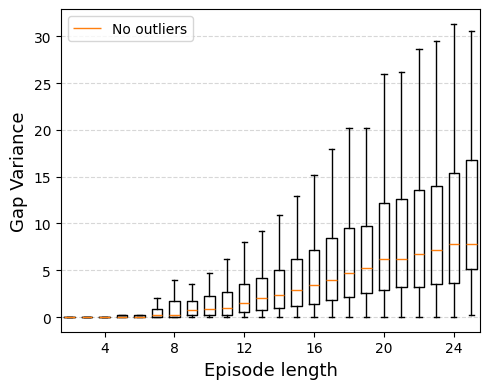

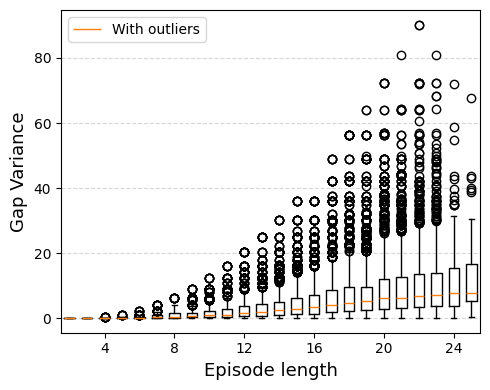

In [22]:
run_id = '5d_state_3d_action'
state_dim = config_models[run_id][0]   # dimension of the state space
action_dim = config_models[run_id][1]  # dimension of the action space
initial_inventory = 25                 # initial inventory X_0
th = 600                               # time horizon T
ts = 25                                # trader time step (in seconds)

trader_times_full = np.concatenate(([0], np.arange(0, th + ts, ts)))
trader_times = trader_times_full[1:]

types = ['twap', 'popv1_half', 'popv2_half', 'popv3', 'popv4', 'ddqn']
run_ids = types[:-1] + [f"ddqn_{run_id}"]
run_labels = ['TWAP', 'POPV1', 'POPV2', 'POPV3', 'POPV4', 'DDQN']
run_names = run_ids

plot_overview(run_names, run_labels, initial_inventory, trader_times, metric='executed', kde_only=True)

run_name = f'ddqn_{run_id}'
path = RESULTS_DIR / f'{run_name}.pkl'
with open(path, 'rb') as f:
    dic = pickle.load(f)
executed = dic['executed']
n = len(trader_times_full)

plot_gap_mean(executed, n)
plot_gap_variance(executed, n)

- Plot Q-values: reproduce Fig. 7. 

- Set `action_idx` (at the bottom of the cell) to plot $Q(\cdot, \text{action\_idx})$. E.g., for the action space [0, 0.5, 1.0], the corresponding indices are $\text{action\_idx} \in \{0,1,2\}$. 

In [23]:
# Dummy env (only needed to instantiate the SB3 policy)
class DummyEnv(gym.Env):
    def __init__(self):
        super().__init__()
        self.observation_space = gym.spaces.Box(low=-1.0, high=1.0, shape=(state_dim,), dtype=float)
        self.action_space = gym.spaces.Discrete(action_dim)
    def reset(self):
        return self.observation_space.sample(), {}
    def step(self, action):
        return self.observation_space.sample(), 0.0, True, False, {}
    
dummy_env = DummyEnv()

# Recreate policy architecture + load weights
policy_kwargs = dict(net_arch=[30, 30, 30, 30, 30], activation_fn=nn.LeakyReLU,)
model = DQN(policy="MlpPolicy", env=dummy_env, policy_kwargs=policy_kwargs, device="cpu",)
path = MODELS_DIR / f"{run_id}_policy.pth"
state_dict = torch.load(path, map_location=model.device)
model.policy.load_state_dict(state_dict)
model.policy.eval();
device = model.device

# Grids (time and inventory are mapped to [-1, 1] and others are z-score normalized)
n_grid = 101
times = np.linspace(-1.0, 1.0, n_grid, dtype=np.float32)
invs  = np.linspace(-1.0, 1.0, n_grid, dtype=np.float32)
T_raw, I_raw = np.meshgrid(times, invs)
time_pct = (T_raw - -1.0) / (1.0 - -1.0) * 100.0
inv_pct  = (I_raw  - -1.0) / (1.0 - -1.0) * 100.0

N = n_grid * n_grid
price, ask_vol, bid_vol = 0.0, 0.0, 0.0 # fixed state components (z-score normalized)
states = np.column_stack([I_raw.reshape(-1), T_raw.reshape(-1), np.full(N, price, np.float32), np.full(N, ask_vol, np.float32), np.full(N, bid_vol, np.float32),]).astype(np.float32)
states = states[:, :state_dim]  # select only the required state dimensions
obs = torch.as_tensor(states, device=device)

# Compute Q(s,a) over the grid 
with torch.no_grad():
    pi = model.policy
    q_tensor = pi.q_net(obs)
q_values  = q_tensor.detach().cpu().numpy()
n_actions = q_values.shape[1]

# Plotly
fig = go.Figure()
for a in range(n_actions):
    Z = q_values[:, a].reshape(n_grid, n_grid)
    fig.add_trace(go.Surface(x=time_pct, y=inv_pct, z=Z, name=f"Action {a}", showscale=(a == 0), colorbar=(dict(title="Q-value") if a == 0 else None)))

### --- CHOOSE ACTION TO DISPLAY --- ###
action_idx = 0
for i in range(n_actions):
    fig.data[i].visible = (i == action_idx)

fig.update_layout(scene=dict(xaxis_title="Time (%)", yaxis_title="Remaining Inventory (%)", zaxis_title="Q-value", aspectmode="cube",),
    margin=dict(l=0, r=0, t=0, b=0), scene_camera=dict(eye=dict(x=2.2, y=2.2, z=1.3)),)